# Visualize the Optimization Process

In [1]:
from datetime import datetime
import itertools
import io

import numpy as np
import scipy.sparse as sp
import scipy as sc
import tensorflow as tf

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

/home/grizzly/Works/University/QC Research/quantum-state-construction/code/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/grizzly/Works/University/QC Research/quantum-state-construction/code/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/grizzly/Works/University/QC Research/quantum-state-construction/code/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be und

In [2]:
dim = 6


In [30]:
def h_generator_tf(batch_size):
    def generate_parametric(n, dv_lambda, name):
        params = tf.get_variable(name, dtype='float64', shape=(batch_size, n), initializer=tf.truncated_normal_initializer)
        params = tf.cast(params, 'complex128')
        places = tf.constant(np.stack([dv_lambda(c) for c in range(n)]), dtype='complex128')
        return tf.tensordot(params, places, axes=[1, 0])
    

    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    h = generate_parametric(dim - 1, neardiag, 'neardiag') + generate_parametric(dim, diag, 'diag')
    
    return h

def solve_tensorflow(dim, h_generator, source, t):
    batch_size = 1
    tf.reset_default_graph()
    
    with tf.device('/cpu:0'):
        source = tf.tile(tf.expand_dims(tf.constant(source, dtype='complex128'), axis=0), [batch_size, 1])
        target = tf.placeholder(dtype='complex128', shape=(batch_size, dim))

        h = h_generator(batch_size)

        gate = tf.linalg.expm(1j * h)
        estimated_target = tf.matmul(gate, tf.expand_dims(source, 2))

        target_dot = tf.matmul(tf.expand_dims(target, 2), estimated_target, adjoint_a=True)
        fidelities = tf.abs(target_dot)
        loss = 1 - tf.reduce_mean(fidelities)

        optimizer = tf.train.MomentumOptimizer(momentum=0.7, learning_rate=0.1)
        gradients = optimizer.compute_gradients(loss)
        optimize_op = optimizer.minimize(loss)
    
    fidelities_val = []
    states_val = []
    gradients_val = []
    parameters_val = []
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        init_op = tf.global_variables_initializer()
        session.run(init_op)
        with tqdm() as qb:
            while len(fidelities_val) < 2 or fidelities_val[-1] < 0.99:
                session.run(optimize_op, feed_dict={target: t})
                states_val.append(session.run(estimated_target, feed_dict={target: t}).squeeze())
                gradients_val.append(session.run(gradients, feed_dict={target: t}))
                parameters_val.append(session.run(h, feed_dict={target: t}).squeeze())
                fidelities_val.append(session.run(fidelities, feed_dict={target: t}).squeeze())
                qb.update()
                qb.set_description("fidelity: %f" % fidelities_val[-1])
                
    return fidelities_val, states_val, gradients_val, parameters_val

In [31]:
target = np.random.randn(dim) + 1j * np.random.randn(dim)
target /= np.linalg.norm(target)

source = np.array([1] + (dim - 1) * [0])


In [32]:
fidelities, states, gradients, parameters = solve_tensorflow(dim, h_generator_tf, source, np.expand_dims(target, axis=0))

In [33]:
def h_generator_np():
    
    neardiag = lambda i : sp.coo_matrix(
        ([1, 1], ([i, (i + 1) % dim], [(i + 1) % dim, i % dim])), shape=(dim, dim)).toarray()

    diag = lambda i : sp.coo_matrix(([1], ([i], [i])), shape=(dim, dim)).toarray()
    return [neardiag(i) for i in range(dim - 1)] + [diag(i) for i in range(dim)]

def solve_numpy(dim, h_generator, source, target, start):
    opt = lambda h : abs(np.vdot(np.matmul(sc.linalg.expm(1j * h), source), target))
    diff = lambda d : (opt(h + eps * d) - opt(h)) / eps

    eps = 0.0001
    step = 0.1

    params = h_generator()
    h = start
    hd = None
    fs = []
    with tqdm() as t:
        while len(fs) < 2 or fs[-1] < 0.99:
            fs.append(opt(h))
            hd = np.zeros((dim, dim))
            for p in params:
                hd += p * (opt(h + eps * p) - opt(h)) / eps
            hd /= abs(hd).sum()
            h += step * hd
            t.update()
            t.set_description("fidelity: %f" % fs[-1])
    return fs, h

In [34]:
fs, h = solve_numpy(dim, h_generator_np, source, target, np.zeros((dim, dim)))

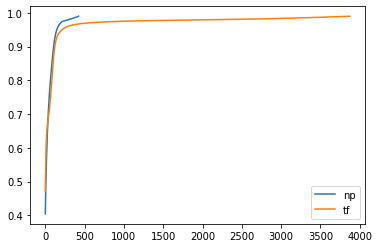

In [29]:
plt.plot(fs, label='np')
plt.plot(fidelities, label='tf')
plt.legend()